In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv("/content/encoded_data.csv")


In [2]:
Label_encode = LabelEncoder()

In [3]:
labels = Label_encode.fit_transform(df.Churn)


In [4]:
#appending labels to dataframe
df["target"] = labels


In [5]:

df["target"].unique()


array([0, 1])

In [6]:
df.drop(columns = ['Churn'],inplace=True)


In [7]:
df.rename(columns = {'target':'Churn'},inplace=True)
print(df.columns)

Index(['gender', 'SeniorCitizen', 'tenure', 'PhoneService', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_One year', 'Contract_Two year',
       'AvgCharges', 'Churn'],
      dtype='object')


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Scale only features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


stratify=y -->Churn is imbalanced, by using this target data will be distributed equally for taining and testing

Stratification keeps the same churn ratio in:

Train set

Test set

Without it → misleading accuracy.

Why Scaling is Required
1. Fair Contribution of Features
2. Faster & Stable Training
3. optimized using gradient descent

## IMP points

Scaling after train-test split --> to prevent data leakage

Don't Scaling the target (y) -->Targets represent class labels, not features. Scaling them destroys class semantics and breaks classification algorithms.

    When can y be scaled?

    Only for regression problems--> House price prediction, Temperature prediction but Never for classification.

not Use fit_transform on test data
  
    fit() Learns statistics -->Mean & Standard deviation, when apply on test data leads  to data leakage

Algorithm	for which Scaling Needed

Logistic Regression	✅ Yes

Linear Regression	✅ Yes

KNN	✅ Yes

SVM	✅ Yes

Neural Networks	✅ Yes

Decision Trees	❌ No

Random Forest	❌ No

XGBoost	❌ No

MinMaxScaler --> sensitive to outliers
| Feature            | StandardScaler    | MinMaxScaler |
| ------------------ | ----------------- | ------------ |
| Mean centered      | Yes               | No           |
| Range              | Unbounded (-infinity to +infinity)         | 0–1          |
| Outlier impact     | Low               | High         |
| Best for           | Linear / Logistic | Neural nets  |
churn project | ✅ Correct         | ❌ Not ideal  |


In [9]:
from sklearn.linear_model import LogisticRegression
                                                  # weights are crucial numerical parameters that determine the strength
model = LogisticRegression(
    max_iter=1000,                              # Allow optimizer up to 1000 steps to find best weights
    class_weight='balanced'             # churn data is imbalanced: class_weight='balanced', Automatically assigns higher weight to minority class
)

model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

Evaluate Model

In [10]:


from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,accuracy_score

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:,1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))




Accuracy: 0.7480482611781405
Confusion Matrix:
 [[755 280]
 [ 75 299]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.81      0.75      0.76      1409


ROC-AUC Score: 0.8483363042186571


threshold tuning for better results

WHEN IS THRESHOLD TUNING REALLY REQUIRED?
Threshold tuning is needed only if:

| Business Need                  | Action           |
| ------------------------------ | ---------------- |
| “Missing churn is very costly” | Tune threshold ↓ |
| “Retention budget is limited”  | Keep default     |
| Recall < 0.6                   | Tune             |
| ROC-AUC < 0.75                 | Improve model    |
| Regulatory / risk sensitivity  | Tune             |


In [11]:
'''
Not needed for this data set, siinc we got good results befor tuning

y_pred_03 = (y_prob >= 0.3).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_03))'''


'\nNot needed for this data set, siinc we got good results befor tuning\n\ny_pred_03 = (y_prob >= 0.3).astype(int)\n\nfrom sklearn.metrics import classification_report\nprint(classification_report(y_test, y_pred_03))'

In [12]:
import joblib

joblib.dump(model, 'logistic_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


#Saved as pkl files for the reusablity
# aim -Train once → Save → Load → Predict


['scaler.pkl']

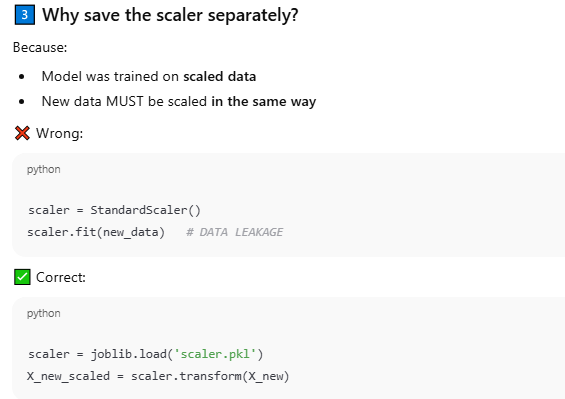

validating saved model using an inference script

In [13]:
import joblib
import pandas as pd

model = joblib.load('logistic_model.pkl')
scaler = joblib.load('scaler.pkl')

sample = pd.DataFrame([{
    'gender': 1,
    'SeniorCitizen': 0,
    'tenure': 5,
    'PhoneService': 1,
    'MultipleLines': 0,
    'OnlineSecurity': 0,
    'OnlineBackup': 1,
    'DeviceProtection': 0,
    'TechSupport': 0,
    'MonthlyCharges': 80,
    'TotalCharges': 400,
    'InternetService_Fiber optic': 1,
    'InternetService_No': 0,
    'Contract_One year': 0,
    'Contract_Two year': 0,
    'AvgCharges': 80
}])

sample_scaled = scaler.transform(sample)

pred = model.predict(sample_scaled)[0]
prob = model.predict_proba(sample_scaled)[0][1]

print("Churn Prediction:", pred)
print("Churn Probability:", prob)


Churn Prediction: 1
Churn Probability: 1.0


Threshold tuning

In [14]:
import numpy as np
from sklearn.metrics import classification_report

custom_threshold = 0.4
y_pred_custom = (y_prob >= custom_threshold).astype(int)

print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.93      0.64      0.76      1035
           1       0.47      0.87      0.61       374

    accuracy                           0.70      1409
   macro avg       0.70      0.75      0.68      1409
weighted avg       0.81      0.70      0.72      1409

